In [ ]:
!pip install albumentations scikit-learn joblib -q

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Mục mới

In [ ]:
!pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

In [ ]:
# LOAD DATASET + CROP FACE

dataset_path = "/content/drive/MyDrive/dataset"
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30,30))
    if len(faces) > 0:
        x, y, w, h = faces[0]
        margin = 20
        x = max(0, x-margin)
        y = max(0, y-margin)
        w = min(img.shape[1]-x, w+2*margin)
        h = min(img.shape[0]-y, h+2*margin)
        face = img[y:y+h, x:x+w]
        return cv2.resize(face, (224,224))
    return None

images = []
labels = []

for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        person_id = int(filename.split("_")[0])
        img = cv2.imread(os.path.join(dataset_path, filename))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        face = detect_and_crop_face(img)
        if face is not None:
            images.append(face)
            labels.append(person_id)

images = np.array(images)
labels = np.array(labels)
print(f"Tổng số ảnh gốc: {len(images)}")

Tổng số ảnh gốc: 375


In [ ]:
#DATA AUGMENTATION
augmenter = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.GaussianBlur(blur_limit=(3,7), p=0.3),
    A.GaussNoise(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5, border_mode=cv2.BORDER_REFLECT_101),
    A.CoarseDropout(max_holes=1, max_height=40, max_width=40, fill_value=0, p=0.3)
])

aug_images = []
aug_labels = []
for img, label in zip(images, labels):
    for _ in range(5):  # 5 ảnh augmented cho mỗi ảnh gốc
        img_aug = augmenter(image=img)["image"]
        aug_images.append(img_aug)
        aug_labels.append(label)

all_images = np.concatenate([images, np.array(aug_images)], axis=0)
all_labels = np.concatenate([labels, np.array(aug_labels)], axis=0)
print(f"Tổng số ảnh sau augmentation: {len(all_images)}")

/tmp/ipython-input-1834900696.py:9: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=40, max_width=40, fill_value=0, p=0.3)


Tổng số ảnh sau augmentation: 2250


In [ ]:
# FINE-TUNE MobileNetV2 + DROPOUT
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False  # freeze tất cả layers trước

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # dropout để giảm overfitting
x = Dense(256, activation='relu')(x)  # dense nhỏ
feature_model = Model(inputs=base_model.input, outputs=x)

def extract_features(imgs):
    features = []
    for img in imgs:
        x_input = preprocess_input(img.astype(np.float32))
        x_input = np.expand_dims(x_input, axis=0)
        feat = feature_model.predict(x_input, verbose=0)
        features.append(feat.flatten())
    return np.array(features)

features = extract_features(all_images)
print(f"Features shape: {features.shape}")

Features shape: (2250, 256)


In [26]:
# TRAIN SVM
X_train, X_test, y_train, y_test = train_test_split(
    features, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

svm = SVC(kernel="linear", C=0.05, class_weight="balanced", probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy: 93.11%
              precision    recall  f1-score   support

           1       0.96      0.97      0.97       120
           2       0.95      0.91      0.93       114
           3       0.92      0.92      0.92       118
           4       0.89      0.92      0.90        98

    accuracy                           0.93       450
   macro avg       0.93      0.93      0.93       450
weighted avg       0.93      0.93      0.93       450



In [27]:
# Lưu model
joblib.dump(svm, "/content/drive/MyDrive/face_svm_finetune.pkl")

['/content/drive/MyDrive/face_svm_finetune.pkl']

Saving WIN_20250906_21_43_21_Pro.jpg to WIN_20250906_21_43_21_Pro.jpg


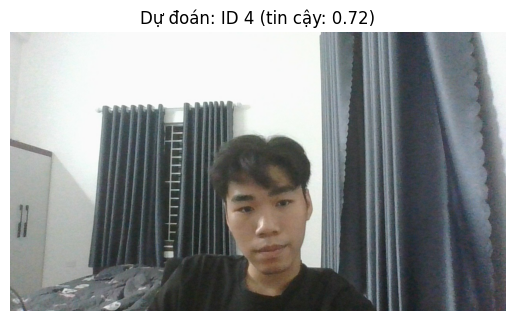

In [34]:
# DỰ ĐOÁN ẢNH
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    test_path = fn

img = cv2.imread(test_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face = detect_and_crop_face(img)

if face is None:
    print("Không tìm thấy khuôn mặt")
else:
    feat = extract_features([face])
    pred_label = svm.predict(feat)[0]
    pred_prob = svm.predict_proba(feat).max()

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Dự đoán: ID {pred_label} (tin cậy: {pred_prob:.2f})")
    plt.show()